<a href="https://colab.research.google.com/github/MehrdadJalali-KIT/BlackHole/blob/main/BlackHoleMethod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')
# Change working path
os.chdir('/content/drive/MyDrive/Research/MOF/Black_Hole')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install rdkit

# Black Hole Strategy for MOF Graphs

In this notebook, we are implementing a **Black Hole Strategy** to refine the graph representation of Metal-Organic Frameworks (MOFs). This approach helps us reduce the complexity of the graph by identifying and removing less influential nodes (MOFs) based on a calculated "gravity" metric. The steps involved in this strategy are as follows:

## 1. Loading the Edge List and Summary Data
We begin by loading the edge list, which defines the relationships (edges) between MOFs (nodes), and the summary data, which contains additional features about the MOFs (such as chemical properties).

- **Edge List**: Contains source and target nodes (MOFs) and their connection weights.
- **Summary Data**: Contains features for each MOF, such as SMILES strings, metal types, and geometric properties like cavity diameter and pore size.

## 2. Constructing the MOF Graph
Using the edge list, we create a graph where each node represents a MOF, and edges represent the relationships between them. This graph allows us to explore the structure and connectivity of the MOFs.

## 3. Detecting Communities
To organize the graph, we apply **community detection**. Communities represent groups of MOFs that are more strongly connected to each other than to other parts of the graph.

- **Girvan-Newman Algorithm**: This algorithm is used to detect communities by iteratively removing edges with high betweenness centrality, splitting the graph into smaller groups.

## 4. Calculating the Gravity Metric
Within each detected community, we calculate a **gravity metric** for each node. This metric combines two centrality measures:
- **Degree Centrality**: Represents how many connections (edges) a node has.
- **Betweenness Centrality**: Represents how often a node acts as a bridge between other nodes in the graph.

The gravity of a node is the sum of its degree and betweenness centrality. Nodes with higher gravity are considered more influential within their communities.

## 5. Applying the Black Hole Strategy
In the Black Hole Strategy, we set a gravity threshold. Nodes (MOFs) with gravity below this threshold are considered less influential and are removed from the graph, along with their associated edges. This results in a "sparsified" graph containing only the most important nodes (black holes) within each community.

## 6. Saving the Sparsified Graph and Features
After removing low-gravity nodes, we save the new edge list of the sparsified graph and the features of the remaining nodes for further analysis. This refined dataset focuses on the most promising MOFs and simplifies future computations.

## 7. Visualizing the Graph
Finally, we visualize the sparsified graph to observe the structure after applying the Black Hole Strategy. The visualization helps us see how the graph has been reduced in complexity and highlights the key communities and their central nodes.

## Benefits of the Black Hole Strategy:
- **Efficiency**: By focusing on the most influential MOFs, we reduce the dataset size and computational cost for further analysis.
- **Clarity**: The resulting graph highlights the most important MOFs, making it easier to identify key candidates for specific applications.


Streaming output truncated to the last 5000 lines.
[09:16:34] DEPRECATION WARNING: please use MorganGenerator
[09:16:34] DEPRECATION WARNING: please use MorganGenerator
[09:16:34] DEPRECATION WARNING: please use MorganGenerator
[09:16:34] DEPRECATION WARNING: please use MorganGenerator
[09:16:34] DEPRECATION WARNING: please use MorganGenerator
[09:16:34] DEPRECATION WARNING: please use MorganGenerator
[09:16:34] DEPRECATION WARNING: please use MorganGenerator
[09:16:34] DEPRECATION WARNING: please use MorganGenerator
[09:16:34] DEPRECATION WARNING: please use MorganGenerator
[09:16:34] DEPRECATION WARNING: please use MorganGenerator
[09:16:34] DEPRECATION WARNING: please use MorganGenerator
[09:16:34] DEPRECATION WARNING: please use MorganGenerator
[09:16:34] DEPRECATION WARNING: please use MorganGenerator
[09:16:34] DEPRECATION WARNING: please use MorganGenerator
[09:16:34] DEPRECATION WARNING: please use MorganGenerator
[09:16:34] DEPRECATION WARNING: please use MorganGenerator
[09:1

Before Black Hole Strategy: 414650 edges, 12561 nodes.
Number of communities detected: 847
After Black Hole Strategy: 194140 edges, 7002 nodes.
Total runtime: 3518.518956184387 seconds
Features of the remaining nodes saved to remaining_node_features_blackhole.csv.


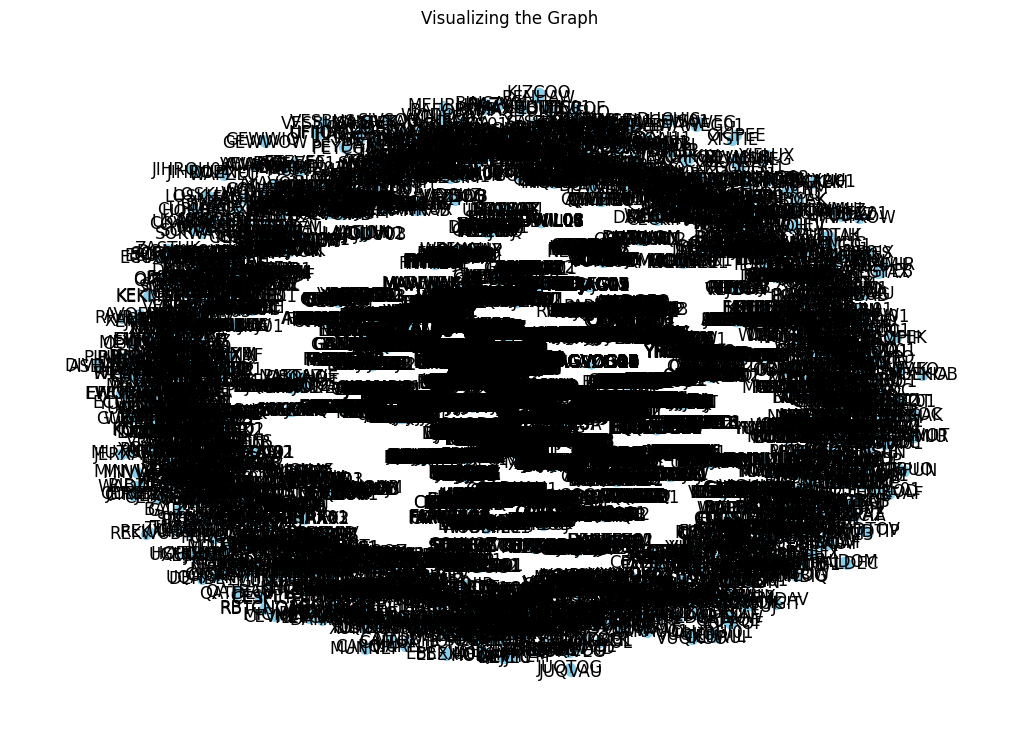

In [10]:
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings

import pandas as pd
import numpy as np
import networkx as nx
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import networkx.algorithms.community as nx_comm
import time
from rdkit import RDLogger
# Suppress specific deprecation warnings and RDKit warnings globally
warnings.filterwarnings("ignore", category=DeprecationWarning)
RDLogger.DisableLog('rdApp.*')

def load_edges_list(filename):
    """Loads edge list from a CSV file."""
    return pd.read_csv(filename)

from rdkit import Chem
from rdkit.Chem import AllChem

def generate_fingerprint(smiles):
    """Generates a molecular fingerprint given a SMILES string using the older method."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            # Return an array of zeros if the molecule can't be parsed
            print(f"SMILES Parse Error: Unable to parse {smiles}")
            return np.zeros((1024,))

        # Generate the fingerprint using AllChem.GetMorganFingerprintAsBitVect
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
        return np.array(fingerprint)
    except Exception as e:
        # Log other errors that may arise
        print(f"SMILES Parse Error: {e}")
        return np.zeros((1024,))  # Return an array of zeros in case of an error


def label_encode_metal_names(metal_names):
    """Encodes metal names as integers."""
    metal_dict = {metal: idx for idx, metal in enumerate(np.unique(metal_names))}
    return np.array([metal_dict[metal] for metal in metal_names])

def load_summary_data(filename, node_labels):
    """Loads summary data and preprocesses it to extract features."""
    summary_data = pd.read_csv(filename, index_col=0)
    linker_smiles = summary_data['linker SMILES']
    linker_features = np.stack(linker_smiles.apply(generate_fingerprint).values)
    metal_names = summary_data['metal']
    metal_features = label_encode_metal_names(metal_names).reshape(-1, 1)
    other_features = summary_data[['Largest Cavity Diameter', 'Pore Limiting Diameter', 'Largest Free Sphere']].values.astype('float32')
    features = np.concatenate((linker_features, metal_features, other_features), axis=1)
    if len(summary_data) == len(node_labels) and all(label in summary_data.index for label in node_labels):
        return pd.DataFrame(features, index=node_labels)
    else:
        print("Warning: Mismatch between summary data and node labels.")
        return pd.DataFrame(features, index=summary_data.index)

def detect_communities(graph):
    """Detects communities in the graph using the Girvan-Newman algorithm."""
    communities_generator = nx_comm.girvan_newman(graph)
    top_level_communities = next(communities_generator)
    communities = [list(community) for community in top_level_communities]
    return communities

def calculate_gravity_per_community(graph, communities):
    """Calculates gravity for each node within its respective community."""
    community_gravity = {}

    for community in communities:
        subgraph = graph.subgraph(community)
        degree_centrality = nx.degree_centrality(subgraph)
        betweenness_centrality = nx.betweenness_centrality(subgraph)

        for node in community:
            # Gravity is the sum of degree and betweenness centrality
            gravity = degree_centrality[node] + betweenness_centrality[node]
            community_gravity[node] = gravity

    return community_gravity

def black_hole_strategy_per_community(graph, gravity, threshold=0.2):
    """Removes nodes with gravity below a certain threshold and their connected edges in each community."""
    nodes_to_remove = [node for node, grav in gravity.items() if grav < threshold]
    graph.remove_nodes_from(nodes_to_remove)
    return graph

def visualize_graph(graph):
    """Visualizes the graph."""
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_size=50, node_color="skyblue", edge_color="gray")
    plt.title("Visualizing the Graph")
    plt.show()

def save_remaining_node_features(graph, summary_data, filename):
    remaining_nodes = list(graph.nodes())
    remaining_features = summary_data.loc[remaining_nodes]
    remaining_features.to_csv(filename, index=False)
    print(f"Features of the remaining nodes saved to {filename}.")

if __name__ == "__main__":
    start_time = time.time()
    edges_list_filename = 'edges_list_0.8_Full_2.csv'
    summary_data_filename = '1M1L3D_summary.csv'
    output_edges_filename = 'sparsified_graph_edges_blackhole.csv'
    output_features_filename = 'remaining_node_features_blackhole.csv'

    edges_list = load_edges_list(edges_list_filename)
    node_labels = pd.concat([edges_list['source'], edges_list['target']]).unique()
    summary_data = load_summary_data(summary_data_filename, node_labels)

    # Construct the graph
    graph = nx.Graph()
    for _, row in edges_list.iterrows():
        graph.add_edge(row['source'], row['target'], weight=row['weight'])

    # Print number of edges and nodes before applying Black Hole Strategy
    print(f"Before Black Hole Strategy: {graph.number_of_edges()} edges, {graph.number_of_nodes()} nodes.")

    # Step 1: Detect communities
    communities = detect_communities(graph)
    print(f"Number of communities detected: {len(communities)}")

    # Step 2: Calculate gravity for each node within its respective community
    gravity_per_community = calculate_gravity_per_community(graph, communities)

    # Step 3: Apply Black Hole Strategy (remove nodes below gravity threshold)
    graph = black_hole_strategy_per_community(graph, gravity_per_community, threshold=0.2)

    # Save the sparsified edge list
    nx.write_edgelist(graph, output_edges_filename, data=['weight'])

    # Print number of edges and nodes after applying Black Hole Strategy
    print(f"After Black Hole Strategy: {graph.number_of_edges()} edges, {graph.number_of_nodes()} nodes.")
    print(f"Total runtime: {time.time() - start_time} seconds")

    save_remaining_node_features(graph, summary_data, output_features_filename)
    visualize_graph(graph)


In [5]:
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings
from rdkit import RDLogger
import pandas as pd
import numpy as np
import networkx as nx
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import networkx.algorithms.community as nx_comm
import time
# Suppress specific deprecation warnings and RDKit warnings globally
warnings.filterwarnings("ignore", category=DeprecationWarning)
RDLogger.DisableLog('rdApp.*')

def load_edges_list(filename):
    """Loads edge list from a CSV file."""
    return pd.read_csv(filename)

def generate_fingerprint(smiles):
    """Generates a molecular fingerprint given a SMILES string."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            # Return an array of zeros if the molecule can't be parsed
            print(f"SMILES Parse Error: Unable to parse {smiles}")
            return np.zeros((1024,))

        # Generate the fingerprint using AllChem.GetMorganFingerprintAsBitVect
        fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
        return np.array(fingerprint)
    except Exception as e:
        # Log other errors that may arise
        print(f"SMILES Parse Error: {e}")
        return np.zeros((1024,))  # Return an array of zeros in case of an error

def label_encode_metal_names(metal_names):
    """Encodes metal names as integers."""
    metal_dict = {metal: idx for idx, metal in enumerate(np.unique(metal_names))}
    return np.array([metal_dict[metal] for metal in metal_names])

def load_summary_data(filename, node_labels):
    """Loads summary data and preprocesses it to extract features."""
    summary_data = pd.read_csv(filename, index_col=0)
    linker_smiles = summary_data['linker SMILES']
    linker_features = np.stack(linker_smiles.apply(generate_fingerprint).values)
    metal_names = summary_data['metal']
    metal_features = label_encode_metal_names(metal_names).reshape(-1, 1)
    other_features = summary_data[['Largest Cavity Diameter', 'Pore Limiting Diameter', 'Largest Free Sphere']].values.astype('float32')
    features = np.concatenate((linker_features, metal_features, other_features), axis=1)

    if len(summary_data) == len(node_labels) and all(label in summary_data.index for label in node_labels):
        return pd.DataFrame(features, index=node_labels)
    else:
        print("Warning: Mismatch between summary data and node labels.")
        return pd.DataFrame(features, index=summary_data.index)

def detect_communities(graph):
    """Detects communities in the graph using the Girvan-Newman algorithm."""
    communities_generator = nx_comm.girvan_newman(graph)
    top_level_communities = next(communities_generator)
    communities = [list(community) for community in top_level_communities]
    print(f"Detected {len(communities)} communities.")
    return communities

def calculate_gravity_per_community(graph, communities):
    """Calculates gravity for each node within its respective community."""
    community_gravity = {}

    for community in communities:
        subgraph = graph.subgraph(community)
        degree_centrality = nx.degree_centrality(subgraph)
        betweenness_centrality = nx.betweenness_centrality(subgraph)

        for node in community:
            # Gravity is the sum of degree and betweenness centrality
            gravity = degree_centrality.get(node, 0) + betweenness_centrality.get(node, 0)
            community_gravity[node] = gravity

    return community_gravity

def black_hole_strategy_per_community(graph, gravity, threshold=0.2):
    """Removes nodes with gravity below a certain threshold and their connected edges in each community."""
    nodes_to_remove = [node for node, grav in gravity.items() if grav < threshold]

    # Debugging: Check if nodes_to_remove is valid
    print(f"Removing {len(nodes_to_remove)} nodes with gravity below {threshold}")

    # Ensure that the nodes are valid
    if all(isinstance(node, (str, int)) for node in nodes_to_remove):
        graph.remove_nodes_from(nodes_to_remove)
    else:
        raise ValueError(f"Invalid nodes detected: {nodes_to_remove}")

    return graph

def visualize_graph(graph):
    """Visualizes the graph."""
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_size=50, node_color="skyblue", edge_color="gray")
    plt.title("Visualizing the Graph")
    plt.show()

def save_remaining_node_features(graph, summary_data, filename):
    remaining_nodes = list(graph.nodes())
    remaining_features = summary_data.loc[remaining_nodes]
    remaining_features.to_csv(filename, index=False)
    print(f"Features of the remaining nodes saved to {filename}.")

if __name__ == "__main__":
    start_time = time.time()
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    edges_list_filename = 'edges_list_0.8_Full_2.csv'
    summary_data_filename = '1M1L3D_summary.csv'
    edges_list = load_edges_list(edges_list_filename)
    node_labels = pd.concat([edges_list['source'], edges_list['target']]).unique()
    summary_data = load_summary_data(summary_data_filename, node_labels)

    # Construct the graph
    graph = nx.Graph()
    for _, row in edges_list.iterrows():
        graph.add_edge(row['source'], row['target'], weight=row['weight'])

    # Detect communities once outside the loop
    communities = detect_communities(graph)

    for threshold in thresholds:
        print(f"Processing for threshold: {threshold}")
        gravity_per_community = calculate_gravity_per_community(graph, communities)
        graph = black_hole_strategy_per_community(graph, gravity_per_community, threshold)
        output_edges_filename = f'sparsified_graph_edges_blackhole_{threshold}.csv'
        output_features_filename = f'remaining_node_features_blackhole_{threshold}.csv'
        nx.write_edgelist(graph, output_edges_filename, data=['weight'])
        save_remaining_node_features(graph, summary_data, output_features_filename)

    print(f"Total runtime: {time.time() - start_time} seconds")


Streaming output truncated to the last 5000 lines.
[12:48:20] DEPRECATION WARNING: please use MorganGenerator
[12:48:20] DEPRECATION WARNING: please use MorganGenerator
[12:48:20] DEPRECATION WARNING: please use MorganGenerator
[12:48:20] DEPRECATION WARNING: please use MorganGenerator
[12:48:20] DEPRECATION WARNING: please use MorganGenerator
[12:48:20] DEPRECATION WARNING: please use MorganGenerator
[12:48:20] DEPRECATION WARNING: please use MorganGenerator
[12:48:20] DEPRECATION WARNING: please use MorganGenerator
[12:48:20] DEPRECATION WARNING: please use MorganGenerator
[12:48:20] DEPRECATION WARNING: please use MorganGenerator
[12:48:20] DEPRECATION WARNING: please use MorganGenerator
[12:48:20] DEPRECATION WARNING: please use MorganGenerator
[12:48:20] DEPRECATION WARNING: please use MorganGenerator
[12:48:20] DEPRECATION WARNING: please use MorganGenerator
[12:48:20] DEPRECATION WARNING: please use MorganGenerator
[12:48:20] DEPRECATION WARNING: please use MorganGenerator
[12:4

Detected 847 communities.
Processing for threshold: 0.1
Removing 3751 nodes with gravity below 0.1
Features of the remaining nodes saved to remaining_node_features_blackhole_0.1.csv.
Processing for threshold: 0.2
Removing 4347 nodes with gravity below 0.2
Features of the remaining nodes saved to remaining_node_features_blackhole_0.2.csv.
Processing for threshold: 0.3
Removing 5090 nodes with gravity below 0.3
Features of the remaining nodes saved to remaining_node_features_blackhole_0.3.csv.
Processing for threshold: 0.4
Removing 5569 nodes with gravity below 0.4
Features of the remaining nodes saved to remaining_node_features_blackhole_0.4.csv.
Processing for threshold: 0.5
Removing 5937 nodes with gravity below 0.5
Features of the remaining nodes saved to remaining_node_features_blackhole_0.5.csv.
Processing for threshold: 0.6
Removing 6284 nodes with gravity below 0.6
Features of the remaining nodes saved to remaining_node_features_blackhole_0.6.csv.
Processing for threshold: 0.7
Re

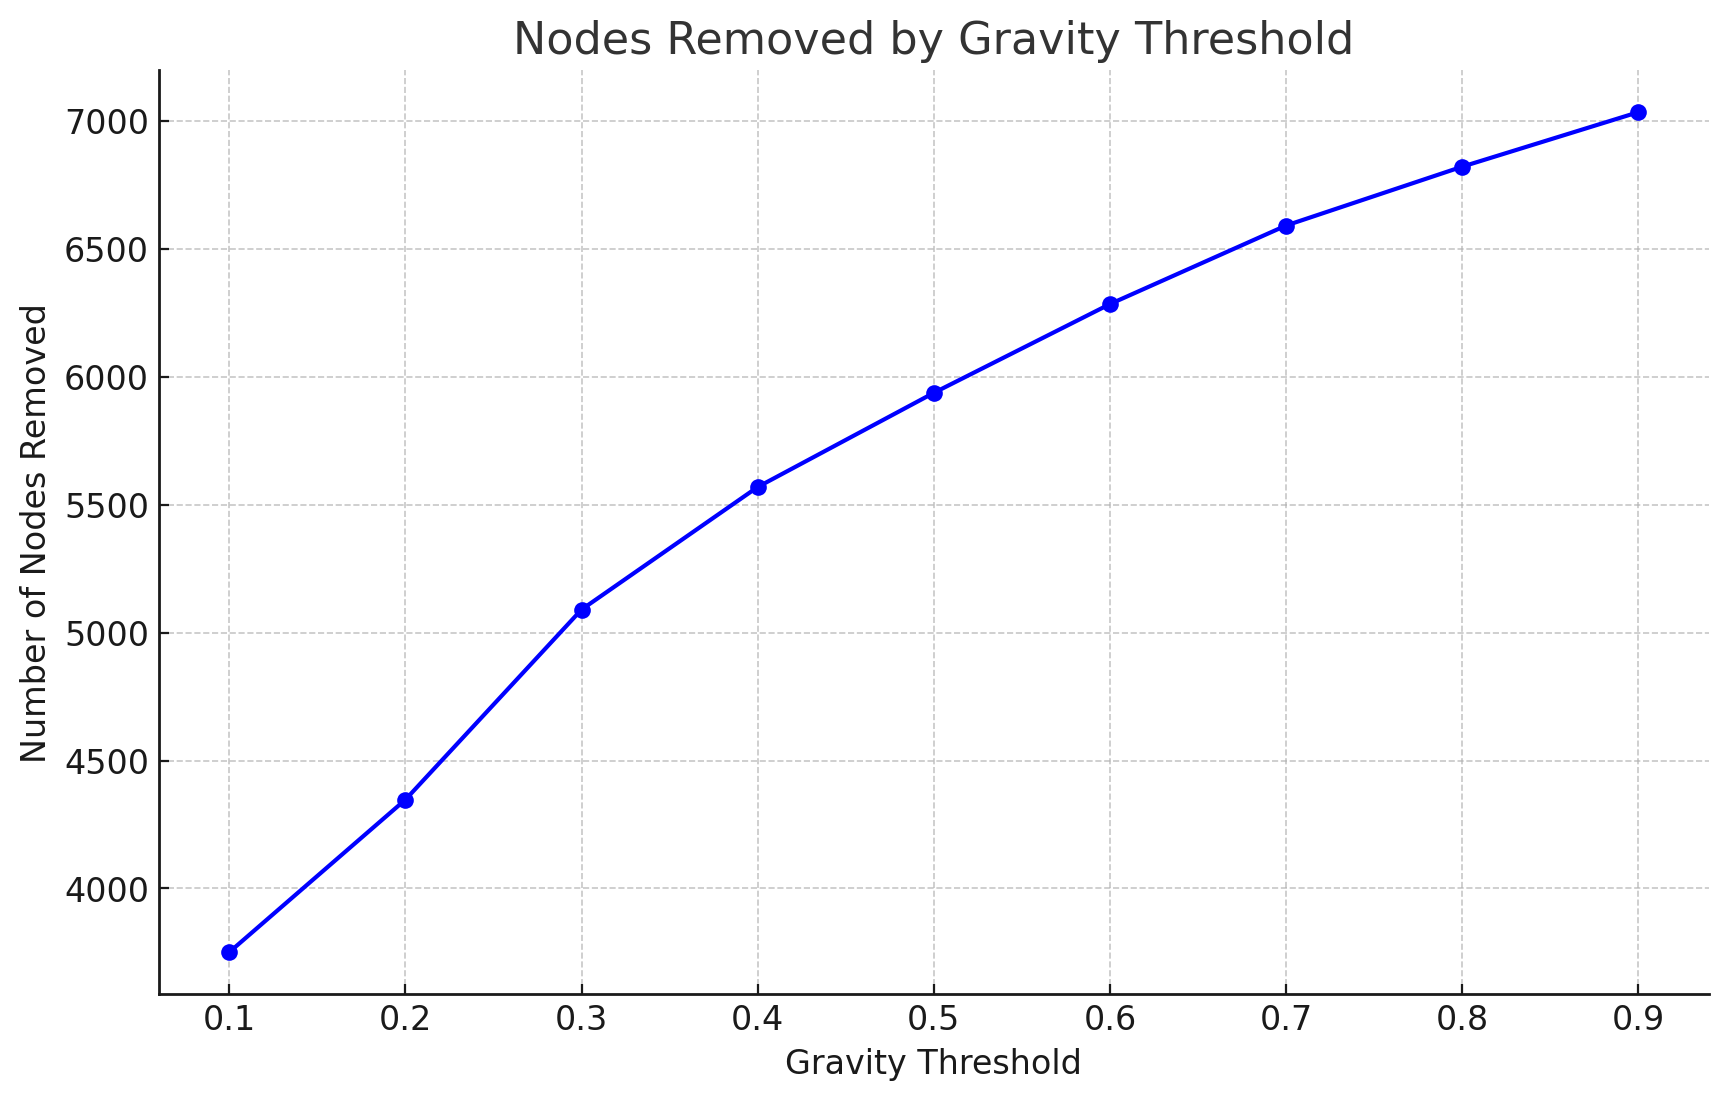